In [ ]:
import os 
import re
import json
import numpy as np
import rasterio
from rasterio.mask import mask
import geopandas as gpd
import pandas as pd
from datetime import datetime
from rasterstats import zonal_stats
from scipy.stats import linregress

In [2]:
BAND_MAP = {"B1": 1, "B2": 2, "B3": 3, "B4": 4, "B5": 5, "B6": 6, "B7": 7}

In [3]:
def scene_date_from_filename(fname):
    # example LC08_L2SP_141041_20230404_20230412_02_T1_SR_B4.TIF
    m = re.search(r"_(\d{8})_", fname)
    if m:
        return datetime.strptime(m.group(1), "%Y%m%d").date()
    return None

In [4]:
def read_band(band_path):
    with rasterio.open(band_path) as src:
        arr = src.read(1).astype("float32")
        profile = src.profile
    return arr, profile

In [5]:
def compute_ndvi(nir, red):
    np.seterr(divide="ignore", invalid="ignore")
    ndvi = (nir - red) / (nir + red)
    ndvi = np.where(np.isfinite(ndvi), ndvi, np.nan)
    return ndvi

In [6]:
def mean_index_in_aoi(index_arr, profile, aoi_geojson):
    # write index to temporary memfile then use zonal_stats or mask
    stats = zonal_stats(
        aoi_geojson,
        index_arr,
        affine=profile["transform"],
        stats=["mean", "median", "count", "std"],
        nodata=np.nan,
    )
    return stats[0]

In [7]:
def process_scene_folder(scene_folder, aoi_geojson):
    """
    Process a single scene folder to compute NDVI statistics over the AOI.
    Automatically reprojects AOI to match raster CRS.
    """
    # find band files
    b4 = next(p for p in os.listdir(scene_folder) if "_SR_B4" in p)
    b5 = next(p for p in os.listdir(scene_folder) if "_SR_B5" in p)
    b4_arr, prof = read_band(os.path.join(scene_folder, b4))
    b5_arr, _ = read_band(os.path.join(scene_folder, b5))
    ndvi = compute_ndvi(b5_arr, b4_arr)
    scene_date = scene_date_from_filename(b4)

    # Reproject AOI to raster CRS
    gdf = gpd.GeoDataFrame.from_features(aoi_geojson["features"], crs="EPSG:4326")
    gdf_utm = gdf.to_crs(prof["crs"])
    aoi_geojson_utm = gdf_utm.__geo_interface__

    stats = mean_index_in_aoi(ndvi, prof, aoi_geojson_utm)
    return {
        "date": scene_date,
        "ndvi_mean": stats["mean"],
        "ndvi_median": stats["median"],
        "count": stats["count"],
        "ndvi_std": stats["std"],
    }


In [14]:
def build_timeseries(data_root, aoi_geojson):
    """
    Build NDVI timeseries for all scenes in data_root.
    """
    rows = []
    for year in os.listdir(data_root):
        ypath = os.path.join(data_root, year)
        if not os.path.isdir(ypath):
            continue
        for month in os.listdir(ypath):
            mpath = os.path.join(ypath, month)
            if not os.path.isdir(mpath):
                continue
            try:
                r = process_scene_folder(mpath, aoi_geojson)
                rows.append(r)
            except StopIteration:
                continue
    df = pd.DataFrame(rows).dropna().sort_values("date").reset_index(drop=True)
    return df


In [15]:
data_root = "../data"
aoi_geojson_path = "../data/aoi.geojson"
with open(aoi_geojson_path) as f:
    aoi_geojson = json.load(f)

In [16]:
df = build_timeseries(data_root, aoi_geojson)
df.head()

,date,ndvi_mean,ndvi_median,count,ndvi_std
0,2022-02-12,0.183799,0.190364,2649889,0.099400
1,2022-03-08,0.214993,0.215458,2649889,0.070530
2,2022-04-17,0.243295,0.243297,2649889,0.076340
3,2022-05-27,0.289824,0.303293,2649889,0.087954
4,2022-10-18,0.303173,0.316262,2649889,0.086264


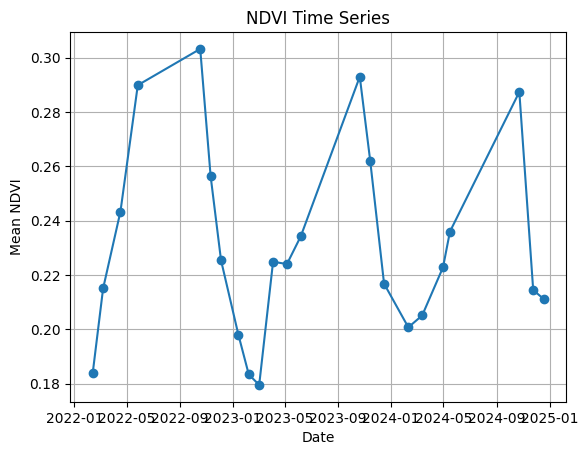

In [11]:
import matplotlib.pyplot as plt

df.sort_values("date", inplace=True)
plt.plot(df["date"], df["ndvi_mean"], marker="o")
plt.xlabel("Date")
plt.ylabel("Mean NDVI")
plt.title("NDVI Time Series")
plt.grid(True)
plt.show()

🌱 Our NDVI (Normalized Difference Vegetation Index) values indicate that:

- **`Vegetation density`**: NDVI around 0.18–0.22 means **sparse or low vegetation**, possibly bare soil or grassland.

- **`Seasonal change`**: Slight increase from March to April/May shows **vegetation growth**, likely due to spring.

- **`Heterogeneity`**: The standard deviation (~0.07–0.09) indicates **variation in vegetation** within your AOI—some patches greener than others.

- **`Coverage`**: Count (~2.6 million) confirms all **AOI pixels were used**, so results are reliable.

✅ In short: Our aoi is mostly low-vegetation, with small seasonal increases.

In [12]:
# Assuming df is your NDVI dataframe with columns: date, ndvi_mean
df = df.sort_values("date")  # ensure sorted by date

# -------------------------
# 1️⃣ Compute linear trend
# -------------------------
x = df["date"].map(datetime.toordinal).values
y = df["ndvi_mean"].values

slope, intercept, r_value, p_value, std_err = linregress(x, y)

print(f"Linear Trend Slope: {slope:.6f} per day")
print(f"R-squared: {r_value**2:.3f}")
print(f"P-value: {p_value:.3f}")


Linear Trend Slope: 0.000001 per day
R-squared: 0.000
P-value: 0.984


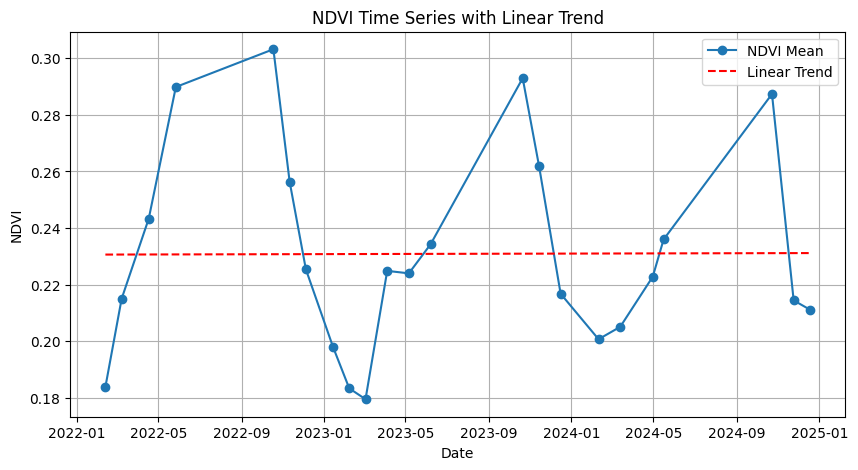

In [13]:
# Create fitted values for plotting trend line
df["trend"] = intercept + slope * x

# -------------------------
# 2️⃣ Plot NDVI over time
# -------------------------
plt.figure(figsize=(10, 5))
plt.plot(df["date"], df["ndvi_mean"], marker="o", linestyle="-", label="NDVI Mean")
plt.plot(df["date"], df["trend"], color="red", linestyle="--", label="Linear Trend")
plt.xlabel("Date")
plt.ylabel("NDVI")
plt.title("NDVI Time Series with Linear Trend")
plt.legend()
plt.grid(True)
plt.show()